In [1]:
# Data Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_label = pd.read_csv('gender_submission.csv')

# Light Data Exploration.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()    # Missing values at Age, Cabin, Embarked.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


So our data can be studied as - 

1. Numeric - 
    a. Continuous - Age, Fare.
    b. Discrete - SibSp, Parch.

2. Categorical - Survived (Target variable), Sex (Male, Female), Embarked.

3. Ordinal - Pclass.

## Analyzing the correlation of the attributes with the target variable.

#### Categorical Attributes.

In [5]:
train[['Survived', 'Sex']].groupby('Sex', as_index = False).mean()   # Assumption - Females had a high Survival chances.

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
train[['Survived', 'Embarked']].groupby('Embarked', as_index = False).mean()    # We can assume that people who had Embarkation at Cherbourg have a higher rate of survival.

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


#### Ordinal Attributes.

In [7]:
train[['Survived', 'Pclass']].groupby('Pclass', as_index = False).mean()    # Sadly high class people had a higher rate of survival.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### Continuous Attributes.

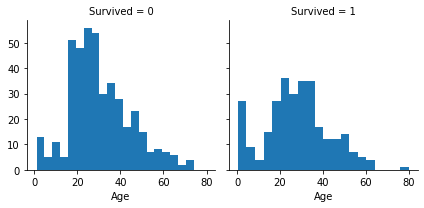

In [8]:
g = sns.FacetGrid(train, col = 'Survived')
g.map(plt.hist, 'Age', bins = 20)           # Assumptions - Children from 0 to 4 years of age had high survival chance.
                                            #               Maximum people from 18 to 20 years of age couldn't survive.
                                            #               People from the age of 75 to 80 were mostly saved.

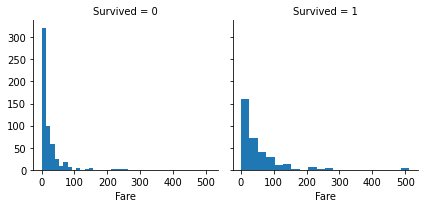

In [9]:
g = sns.FacetGrid(train, col = 'Survived')
g.map(plt.hist, 'Fare', bins = 20)                    # Survival can be assumed to have a slight correlation with fare.

In [10]:
train[['Survived', 'SibSp']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)
# We can see a trend of negative correlation in the survival rate and the number of Siblings/Spouse on board.

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
train[['Survived', 'Parch']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


#### So we can build assumptions that:
#### More of the Females survived. 
#### Maybe Embarkation had a role in the rate of Survival. 
#### More of the children and old people were saved.
#### People with a big family had low chances of being saved.
#### Those who paid more fare survived.
#### Class of the people had a hig correlation with the survival chances.

# Feature Engineering.

### One might be interested in knowing if the person who didn't have any family onboard had a high chances of surviving or the one with family had.

In [12]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

In [13]:
train['IsAlone'].value_counts()

1    537
0    354
Name: IsAlone, dtype: int64

In [14]:
train[['Survived', 'IsAlone']].groupby('IsAlone', as_index = False).mean()   # we can assume that people with family were saved, and the people with no family couldn't be saved.

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [15]:
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1
test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

#### Dropping the attributes as we leave the work to IsAlone attribute.

In [16]:
train = train.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1)
test = test.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1)

### We can also use the name attribute to extract the title of the people to see if there is any trend.

In [17]:
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [18]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Capt              1
Lady              1
Sir               1
Jonkheer          1
Don               1
the Countess      1
Ms                1
Mme               1
Name: Title, dtype: int64

In [19]:
# Replacing titles with known ones.
train['Title'] = train['Title'].replace(['the Countess', 'Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'others')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

test['Title'] = test['Title'].replace(['the Countess', 'Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'others')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

In [20]:
train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
others     23
Name: Title, dtype: int64

In [21]:
train[['Title', 'Survived']].groupby('Title', as_index = False).mean().sort_values(by = 'Survived', ascending = False)
# Assumption - Females and young males had high chances of survival.

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,others,0.347826
2,Mr,0.156673


#### Dropping the Name, Cabin and PassengerId attributes.

In [22]:
train = train.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis = 1)
test_id = test['PassengerId'].copy()
test = test.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis = 1)

So finally after Analysis of Data and some feature engineering assumptions in our hand are: 
So we can build assumptions that:
More of the Females survived. 
Maybe Embarkation had a role in the rate of Survival. 
More of the children and old people were saved.
People with a big family had low chances of being saved.
Those who paid more fare survived.
Class of the people had a hig correlation with the survival chances.
From the Family size we got to know people with family survived while those who were alone didn't.
From title we can assume that females and young males were the majority who survived.

# Data Cleaning.

In [23]:
# Handling missing values at Embarked. We take the most frequently appearing instance of Embarked.
freq = train['Embarked'].dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(freq)

#### Seperating the features and the label from the train set.

In [24]:
train_set = train.drop('Survived', axis = 1)
train_label = train['Survived'].copy()

#### Creating pipeline to clean the dataset.

In [25]:
ordinal_conversion = ['Sex', 'Title', 'Embarked']
num_attribs = ['Pclass', 'Age', 'Fare', 'IsAlone']

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),    # To fill missing values with median.
    ('scale', StandardScaler())                        # To scale all attributes at same level.
])

ord_pipe = Pipeline([
    ('OrdinalEncoder', OrdinalEncoder())               # To convert categorical data into ordinal numeric form.
])

full_pipe = ColumnTransformer([
    ('num', num_pipe, num_attribs),
    ('ord', ord_pipe, ordinal_conversion)
])

#### Cleaning the train set.

In [26]:
train_prepared = full_pipe.fit_transform(train_set)
test_prepared = full_pipe.fit_transform(test)

# Training the models.

#### Logistic Regression.

In [27]:
logReg = LogisticRegression()
logReg.fit(train_prepared, train_label)

LogisticRegression()

In [28]:
logReg_preds = logReg.predict(train_prepared)

In [29]:
accuracy_score(train_label,logReg_preds)

0.7912457912457912

In [30]:
confusion_matrix(train_label, logReg_preds)

array([[468,  81],
       [105, 237]], dtype=int64)

#### SVC

In [31]:
svc = SVC()
svc.fit(train_prepared, train_label)

SVC()

In [32]:
svc_preds = svc.predict(train_prepared)

In [33]:
accuracy_score(train_label, svc_preds)

0.8305274971941639

In [34]:
confusion_matrix(train_label, logReg_preds)

array([[468,  81],
       [105, 237]], dtype=int64)

#### KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_prepared, train_label)

KNeighborsClassifier()

In [36]:
knn_preds = knn.predict(train_prepared)

In [37]:
accuracy_score(train_label, knn_preds)

0.8552188552188552

In [38]:
confusion_matrix(train_label, knn_preds)

array([[491,  58],
       [ 71, 271]], dtype=int64)

#### Decision Tree

In [39]:
treeClf = DecisionTreeClassifier()
treeClf.fit(train_prepared, train_label)
tree_preds = treeClf.predict(train_prepared)

In [40]:
accuracy_score(train_label, tree_preds)         # Overfitting

0.9820426487093153

In [41]:
confusion_matrix(train_label, tree_preds)

array([[547,   2],
       [ 14, 328]], dtype=int64)

#### Random Forest

In [42]:
forestClf = RandomForestClassifier()
forestClf.fit(train_prepared, train_label)
forest_preds = forestClf.predict(train_prepared)

In [43]:
accuracy_score(train_label, forest_preds)    # Overfitting

0.9820426487093153

In [44]:
confusion_matrix(train_label, forest_preds)

array([[547,   2],
       [ 14, 328]], dtype=int64)

# Hyperparameter Tuning.

#### SVC

In [45]:
param_grid = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]

svc_tuning = SVC()
grid_search = GridSearchCV(svc_tuning, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(train_prepared, train_label)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='accuracy')

In [46]:
grid_search.best_params_

{'kernel': 'poly'}

In [47]:
svc = SVC(kernel = 'poly')
svc.fit(train_prepared, train_label)
svc_preds = svc.predict(train_prepared)

In [48]:
accuracy_score(train_label, svc_preds)

0.8338945005611672

#### Random Forest Classifier.

In [49]:
param_grid = [
    {'criterion':['gini', 'entropy'], 'n_estimators':[10, 20, 30, 100], 'max_features': ['auto', 'sqrt', 'log2']}
]
forest_tuning = RandomForestClassifier()
for_grid = GridSearchCV(forest_tuning, param_grid, cv = 5, scoring = 'accuracy')
for_grid.fit(train_prepared, train_label)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [10, 20, 30, 100]}],
             scoring='accuracy')

In [50]:
for_grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 20}

In [51]:
forestClf = RandomForestClassifier(criterion =  'gini', max_features = 'sqrt', n_estimators = 10)
forestClf.fit(train_prepared, train_label)
forest_preds = forestClf.predict(train_prepared)

In [52]:
accuracy_score(train_label, forest_preds)

0.9708193041526375

#### KNN

In [53]:
param_grid = [
    {'n_neighbors':[3,4,5,6,7], 'metric':['euclidean','manhattan','minkowski','chebyshev']}
]
knn_tuning = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_tuning, param_grid, cv = 5, scoring = 'accuracy')
knn_grid.fit(train_prepared, train_label)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan', 'minkowski',
                                     'chebyshev'],
                          'n_neighbors': [3, 4, 5, 6, 7]}],
             scoring='accuracy')

In [54]:
knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5}

In [55]:
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5)
knn.fit(train_prepared, train_label)
knn_preds = knn.predict(train_prepared)

In [56]:
accuracy_score(train_label, knn_preds)

0.8686868686868687

# Predicting over test set.

#### SVC

In [57]:
svc = SVC(kernel = 'poly')
svc.fit(train_prepared, train_label)
svc_preds = svc.predict(test_prepared)
accuracy_score(test_label['Survived'], svc_preds)

0.9186602870813397

#### RandomForestClassifier

In [58]:
forestClf = RandomForestClassifier(criterion =  'gini', max_features = 'sqrt', n_estimators = 10)
forestClf.fit(train_prepared, train_label)
forest_preds = forestClf.predict(test_prepared)
accuracy_score(test_label['Survived'], forest_preds)

0.8325358851674641

#### KNN

In [59]:
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5)
knn.fit(train_prepared, train_label)
knn_preds = knn.predict(test_prepared)
accuracy_score(test_label['Survived'], knn_preds)

0.8133971291866029